# Using the Elastic Scattering Template

Let’s start by running {{bfrescox}} on a simple example: proton elastic scattering off a $^{78}$ Ni target at a laboratory energy of 50 MeV. To do this, we’ll make use of the built-in **template** and input generator provided by {{bfrescox}} to set up the reaction and build a full {{frescox}} **input file**. This system is part of the canonical set of examples provided in the [{{fresco}}](https://www.fresco.org.uk/examples/index.html) website.

In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import inspect
import pandas as pd
import json

with open("MatplotlibEsthetics.json", "r") as fptr:
    esthetics = json.load(fptr)

plt.style.use(esthetics["style"])
FONTSIZE      = esthetics["fontsize"]
TICK_FONTSIZE = esthetics["tick_fontsize"]
MARKERSIZE    = esthetics["markersize"]
LINEWIDTH     = esthetics["linewidth"]

# TODO: We should be able to remove this eventually with the
# next change to the run_simulation() interface.
if Path.cwd().joinpath("78Ni_p_elastic_example").exists():
    shutil.rmtree(Path.cwd().joinpath("78Ni_p_elastic_example"))

## Generating the {{frescox}} Input

The construction of a {{frescox}} **input file** from a {{bfrescox}} template involves two main steps:

1. **Create the {{bfrescox}} template**  
   Begin by setting up a **template** that includes the defininition of your overall scattering system.  The template is a Fortran namelist (NML) file that includes your specification of:
   - the projectile and target **masses** and **spins**
   - the **laboratory energy**
   - the number of **partial waves**
   - the **Coulomb radius**

   At this stage, however, the interaction parameters are left as **placeholders** to be filled in later in the NML file.  In other words, this file is **not** a valid {{frescox}} input file.

2. **Generate the complete {{frescox}} input file**  
   Once the **template** is defined and all system properties are specified, you can replace the **placeholder** parameters with their actual numerical values.  This produces a fully specified **input file** ready to be passed to {{frescox}} for the reaction calculation.


For subsequent calculations involving the same reaction system, you only need to perform step&nbsp;2 — reusing the existing **template** and updating the parameter values as needed.

Let's see how this works, step by step. We'll begin by assigning appropriate names to the {{frescox}} **template**, **input** and **output** files as well as by creating a new folder that will hold all {{frescox}} input and output files for our simulation.

**TODO**:
* With the next bfrescox interface update, users should just pass to `run_simulation()` the folder name
* Do users need to specify a input file name?  stdout filename?
* Folder created automatically?  Overwriting?

In [2]:
# Folder to which all frescox input/output files should be written to
RESULTS_FOLDER = Path.cwd().joinpath("78Ni_p_elastic_example")

# Name the general template file for your problem
TEMPLATE_NAME = RESULTS_FOLDER.joinpath("78Ni_p_elastic_example.template")
# Name the frescox input file to be generated
FRESCOX_INPUT = Path.cwd().joinpath("frescox.in")
# Name the frescox output file to be generated (the standard output name)
FRESCOX_OUTPUT = RESULTS_FOLDER.joinpath("stdout.log")
# Name of the fort.16 Frescox output file
FRESCOX_FORT_16 = RESULTS_FOLDER.joinpath("fort.16")

os.mkdir(RESULTS_FOLDER)

### Create the {{bfrescox}} template
Now let's define the **masses**, **spins**, **energy**, **number of partial waves**, and **Coulomb radius** of the system in a Python dictionary, which `bfrescox.generate_elastic_template()` uses to  populate our {{bfrescox}} **template**.

In [3]:
import bfrescox

elastic_scattering_system =  {
          "target_mass_amu" : 78,
          "target_atomic_number" : 28,
          "target_spin" : 0,
          "projectile_mass_amu" : 1,
          "projectile_atomic_number" : 1,
          "projectile_spin" : "1/2",
          "E_lab_MeV": 50.0,
          "J_tot_min": 0.0,
          "J_tot_max": 60.0,
          "R_match_fm": 60.0,
          "E_0_MeV": 0.0,
          "step_size_fm": 0.1,
          "reaction_name": "p+Ni78 Coulomb + Nuclear"
        }

bfrescox.generate_elastic_template(
    TEMPLATE_NAME, **elastic_scattering_system
)

We now have generated the {{bfrescox}} **template** for the system! Let's see what this looks like.

In [4]:
with open(TEMPLATE_NAME, "r") as temp:
    generated_content = temp.read()

print("Generated Bfrescox Template:")
print("-----------------------------------")
print(generated_content)

Generated Frescox Template:
-----------------------------------
p+Ni78 Coulomb + Nuclear
NAMELIST
&FRESCO hcm=0.100000000 rmatch=60.000000000
    jtmin=0.0 jtmax=60.0 absend= 0.01
  thmin=0.00 thmax=180.00 thinc=1.00
    iter=0 ips=0.0 iblock=0 chans=1 smats=2  xstabl=1
  wdisk=2
    elab(1)=50.000000000 treneg=1 /

 &PARTITION namep='projectile' massp=1.000000000 zp=1.000000000
            namet='target'   masst=78.000000000 zt=28.000000000 qval=-0.000 nex=1  /
 &STATES jp=0.5 bandp=1 ep=0.0000 cpot=1 jt=0.0 bandt=1 et=0.000000000 /
 &partition /

 &POT kp=1 ap=1.000000000 at=78.000000000 rc=@rC@  /
 &POT kp=1 type=1  p1=@V@ p2=@r@ p3=@a@ p4=@W@ p5=@rw@ p6=@aw@ /
 &POT kp=1 type=2  p1=@Vs@ p2=@rs@ p3=@as@ p4=@Ws@ p5=@rws@ p6=@aws@ /
 &POT kp=1 type=3  p1=@Vso@ p2=@rso@ p3=@aso@ p4=@Wso@ p5=@rwso@ p6=@awso@ /

 &pot /
 &overlap /
 &coupling /



Great! All system quantities are now defined and in place for the reaction we want to run. The parameter **placeholders** are put in place, each one is labeled as `@<parameter name>@` in the **template**.
All that is left is to replace the **placeholder** interaction parameters in the template with their actual numerical values. Let's do that next.

### Generate the complete {{frescox}} **input file**

Similar to how we set up our system, we specify the full set of parameter values to use for a single {{frescox}} run of our scattering system in a Python Dictionary whose keys are the `<parameter name>` strings in the template's placeholders. This information is used by `bfrescox.Configuration.from_template()` to generate the final {{frescox}} input.

In [5]:
elastic_optical_model_parameters = {
    "rC":  1.2,
    "V":  40.0, "r":   1.2, "a":   0.65, "W":  10.0, "rw":   1.2, "aw":   0.5,
    "Vs":  0,   "rs":  1.2, "as":  0.5,  "Ws":  0,   "rws":  1.2, "aws":  0.5,
    "Vso": 0,   "rso": 1.0, "aso": 0.65, "Wso": 0,   "rwso": 1.0, "awso": 0.65   
}

cfg = bfrescox.Configuration.from_template(
    TEMPLATE_NAME,
    FRESCOX_INPUT,
    elastic_optical_model_parameters,
    overwrite=True,
)

We now have generated the {{frescox}} **input file** from the **template**! Let's see what this looks like.

**TODO**:
* Are some of those X.XXXXX values passed to configurations that are fundamentally integers (e.g., massp)?

In [6]:
with open(FRESCOX_INPUT, "r") as input:
    generated_content = input.read()

print("Generated Frescox Input:")
print("-----------------------------------")
print(generated_content)

Generated Frescox Input:
-----------------------------------
p+Ni78 Coulomb + Nuclear
NAMELIST
&FRESCO hcm=0.100000000 rmatch=60.000000000
    jtmin=0.0 jtmax=60.0 absend= 0.01
  thmin=0.00 thmax=180.00 thinc=1.00
    iter=0 ips=0.0 iblock=0 chans=1 smats=2  xstabl=1
  wdisk=2
    elab(1)=50.000000000 treneg=1 /

 &PARTITION namep='projectile' massp=1.000000000 zp=1.000000000
            namet='target'   masst=78.000000000 zt=28.000000000 qval=-0.000 nex=1  /
 &STATES jp=0.5 bandp=1 ep=0.0000 cpot=1 jt=0.0 bandt=1 et=0.000000000 /
 &partition /

 &POT kp=1 ap=1.000000000 at=78.000000000 rc=1.200000000  /
 &POT kp=1 type=1  p1=40.000000000 p2=1.200000000 p3=0.650000000 p4=10.000000000 p5=1.200000000 p6=0.500000000 /
 &POT kp=1 type=2  p1=0.000000000 p2=1.200000000 p3=0.500000000 p4=0.000000000 p5=1.200000000 p6=0.500000000 /
 &POT kp=1 type=3  p1=0.000000000 p2=1.000000000 p3=0.650000000 p4=0.000000000 p5=1.000000000 p6=0.650000000 /

 &pot /
 &overlap /
 &coupling /



## Running elastic scattering with {{bfrescox}}

Now that we have generated the {{frescox}} **input file**, running the elastic scattering calculation is extremely easy!

In [7]:
bfrescox.run_simulation(cfg, FRESCOX_OUTPUT, cwd=RESULTS_FOLDER, overwrite=True)

Done! All we need to do is parse the results and extract the physical quantities we want. Let's focus on extracting the cross sections from the **output files**.

## Parsing Elastic Scattering Cross Sections
For this particular scattering system setup, {{frescox}} writes the ratio to Rutheford cross sections fo the **fort.16** file (among others **TBC**).  Let's extract those cross sections for our example case as a DataFrame.

In [8]:
fort16_df = bfrescox.parse_fort16(FRESCOX_FORT_16)
r2R_df = fort16_df["channel_1"]

Let's see what the cross sections look like!

**TODO**:
* Happy with this DataFrame structure and index/column names?

In [9]:
display(r2R_df.head())

,Theta,sigma
0,0.01,1.0000
1,1.00,0.9956
2,2.00,0.9106
3,3.00,0.7792
4,4.00,0.6609


## Visualizing cross sections and benchmarks

A visualization of the results in that DataFrame shows nice results.

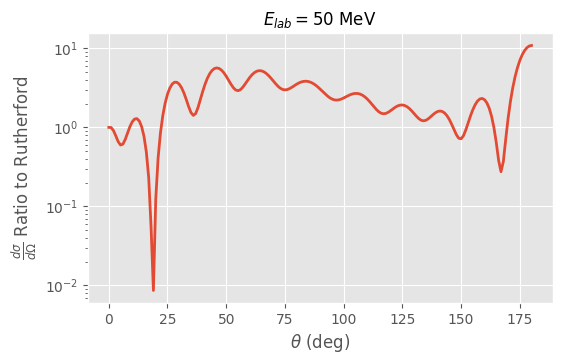

In [10]:
fig = plt.figure(1, figsize=(6, 3.5))

subp = fig.add_subplot(111)
subp.set_title(r"$E_{lab} = 50$ MeV", fontsize=FONTSIZE)
subp.plot(r2R_df.Theta, r2R_df.sigma, lw=LINEWIDTH)
subp.set_yscale('log')
subp.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ Ratio to Rutherford", fontsize=FONTSIZE)
subp.set_xlabel(r"$\theta$ (deg)", fontsize=FONTSIZE)
subp.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)

Let's also confirm that our results obtained with {{bfrescox}} match a benchmark calculation obtained using a standard {{frescox}} installation.  We'll load this benchmark first from our {{bfrescox}} installation.

In [11]:
data_path = (
    Path(inspect.getfile(bfrescox))
    .resolve()
    .parent
    .joinpath("tests", "TestData")
)

baseline_file = data_path / "Ni78_p_elastic_PointA_differential_xs_baseline.csv"
expected = np.loadtxt(baseline_file, delimiter=",")

**TODO**:
* Since you are using heavily rounded data, I suspect that in the above cell you could just put an assert statement that confirms that the two results are identical.  No need for the following visualization.

Great! Our {{bfrescox}} calculations match the benchmark results!

Let's make a plot comparing the benchmark and our {{bfrescox}} result and see their absolute difference across the angular range.

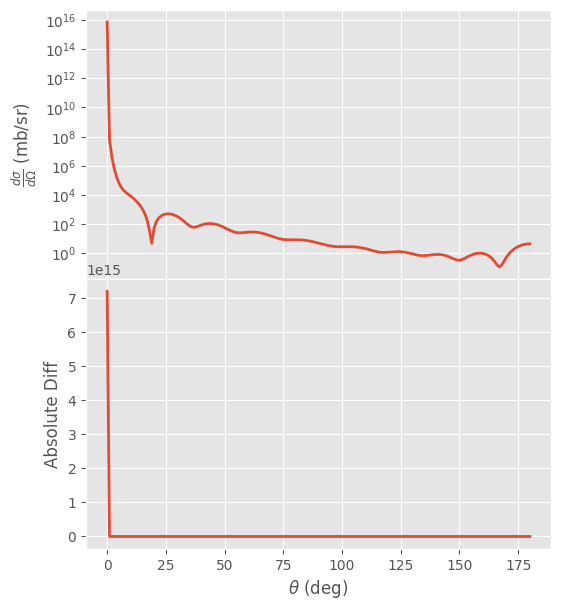

In [12]:
# Create figure and axes that share all axes
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(6, 7),
    sharex=True, sharey=False
)
plt.subplots_adjust(hspace=0)  # remove gap

# Plot differential cross section
ax1.plot(expected[:,0], expected[:,1], lw=LINEWIDTH)
ax1.set_yscale('log')
ax1.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ (mb/sr)", fontsize=FONTSIZE)
ax1.set_xlabel(r"$\theta$ (deg)", fontsize=FONTSIZE)
ax1.tick_params(axis='both', labelsize=TICK_FONTSIZE)

ax2.plot(r2R_df.Theta, np.abs(r2R_df.sigma - expected[:,1]),
         lw=LINEWIDTH)
#ax2.set_yscale('log')
ax2.set_ylabel(r"Absolute Diff", fontsize=FONTSIZE)
ax2.set_xlabel(r"$\theta$ (deg)", fontsize=FONTSIZE)
ax2.tick_params(axis='both', labelsize=TICK_FONTSIZE)